In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import os
from PIL import Image
from pickle import dump, load
from torchvision import transforms


In [2]:
def load_images(images_folder, save_file_to=None):
    X_original = []
    X = []
    y = []
    
    for subdir, dirs, files in os.walk(images_folder):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(subdir, file)
                label = os.path.basename(subdir)
                
                image = Image.open(img_path).convert('L')
                image = image.resize((48, 48))
                X_original.append(np.array(image).flatten())
                X.append(np.array(image).flatten())
                y.append(label)
                
    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_original, X, y), f, protocol=5)
                
    return np.array(X_original), np.array(X), np.array(y)

images_folder = '../images'
dataset_file = "dataset_dump.pkl"

# Load images and save the dataset for reuse
X_original, X, y = load_images(images_folder, save_file_to=dataset_file)

In [4]:
with open("/Users/shaneab/Projects/Machine Learning/Expression recognition/jonathanheix dataset/dump/dataset_dump.pkl", "rb") as f:
    X_original,X,y = load(f)

In [5]:
# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)


In [6]:
# Preprocessing data function
def preprocessing_data(X, y, save_file_to=None):
    # Normalize pixel values
    X = X / 255.0  # Normalize to [0, 1]

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    if save_file_to:
        with open(save_file_to, "wb") as f:
            dump((X_scaled, y_encoded, label_encoder, scaler), f, protocol=5)

    return X_scaled, y_encoded, label_encoder, scaler

# Process the data and save
X_scaled, y_encoded, label_encoder, scaler = preprocessing_data(X, y, save_file_to="labelencoder_standardscaler_normalizers_dump.pkl")

In [35]:
with open("labelencoder_standardscaler_normalizers_dump.pkl", "rb") as f:
    X_scaled, y_encoded, label_encoder, scaler = load(f)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


In [37]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [39]:
# Define data augmentation transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Apply transformations to your dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx].reshape(48, 48, 1)
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = CustomDataset(X_train, y_train, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [40]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2304, 100)  # Adjust input size to match flattened image size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, len(np.unique(y_encoded)))  # Output size matches the number of classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [41]:
# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [44]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [5/100], Loss: 1.7194
Epoch [10/100], Loss: 1.7646
Epoch [15/100], Loss: 1.8705
Epoch [20/100], Loss: 1.7277
Epoch [25/100], Loss: 1.8042
Epoch [30/100], Loss: 1.8258
Epoch [35/100], Loss: 1.8727
Epoch [40/100], Loss: 1.8073
Epoch [45/100], Loss: 1.7961
Epoch [50/100], Loss: 1.7446
Epoch [55/100], Loss: 1.8832
Epoch [60/100], Loss: 1.7301
Epoch [65/100], Loss: 1.7766
Epoch [70/100], Loss: 1.7748
Epoch [75/100], Loss: 1.7608
Epoch [80/100], Loss: 1.8388
Epoch [85/100], Loss: 1.7175
Epoch [90/100], Loss: 1.7577
Epoch [95/100], Loss: 1.7119
Epoch [100/100], Loss: 1.7065


In [45]:

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 19.63%


In [ ]:

# Save the model
torch.save(model.state_dict(), "simple_nn_model_v2.pth")
print("Model saved successfully!")

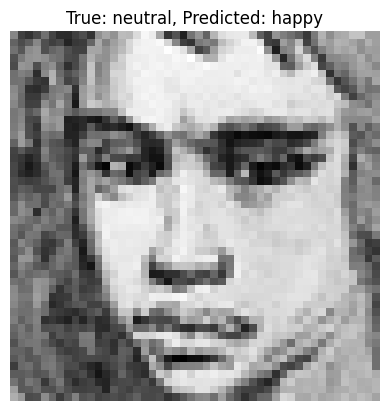

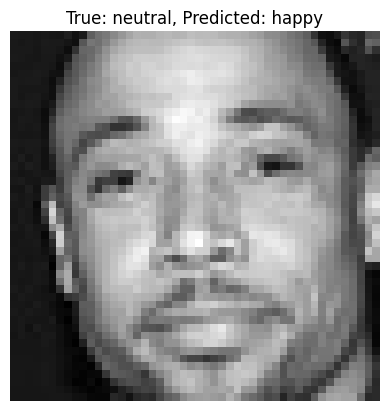

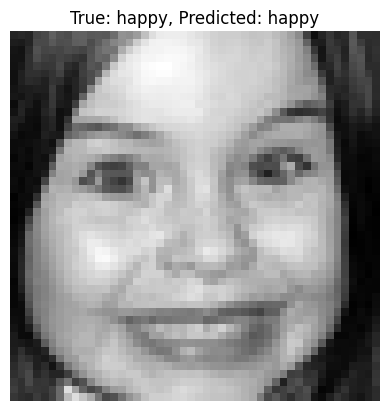

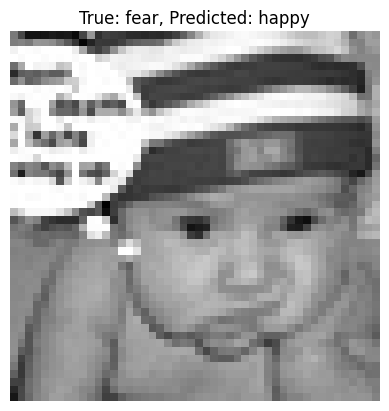

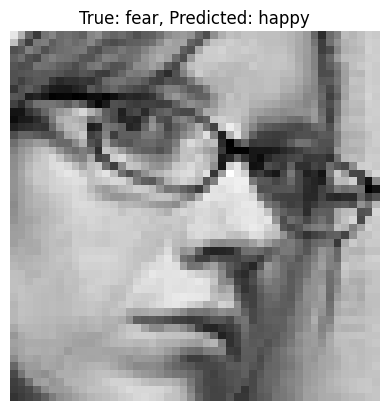

In [30]:
# Visualize predictions
def visualize_predictions(model, X_test, y_test, label_encoder, X_original):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, y_pred = torch.max(outputs.data, 1)
    
    random_indices = np.random.randint(0, len(y_test), 5)
    
    for idx in random_indices:
        original_image = X_original[idx].reshape(48, 48)  # Reshape to 48x48
        plt.imshow(original_image, cmap='gray')
        plt.title(f"True: {label_encoder.inverse_transform([y_test[idx]])[0]}, "
                  f"Predicted: {label_encoder.inverse_transform([y_pred[idx]])[0]}")
        plt.axis('off')
        plt.show()

visualize_predictions(model, X_test_tensor, y_test_tensor, label_encoder, X_original)